<font size="5">Cycling Profolio Project

<font size="5">**Introduction**

This is final project from google data analyst certificate.


The project is carried out by following the 6 steps of the data analysis process: 

* Ask
* Prepare
* Process
* Analyze
* Share 
* Act

    
    
**Resoruces**

Cyclistic’s historical trip data has been published [here](https://divvy-tripdata.s3.amazonaws.com/index.html).  

<font size="5">**Ask**</font>


There are three suggested questions to guide the whole project:
1. How do annual members and casual riders use Cyclistic bikes differently?
2. Why would casual riders buy Cyclistic annual memberships?
3. How can Cyclistic use digital media to influence casual riders to become members?

Due to some formatting issue, I will be only using September's user data, the following analyses are made based on only September's cycling dataset, so the only question this analysis will be answering is:
"How do monthly members and casual riders use Cyclistic bikes differently?"


<font size="5">**Prepare**</font>

According to the project guidance, two additional columns were added to each file:

* **ride_length**: It is the difference between ended_at and started_at.
data type: TIME 
Format: HH:MM:SS
* **day_of_week**: It is the day of the week when the ride started (from the started_at column).
data type: STRING 
Format: “Monday”, “Tuesday”, etc.



<font size="4">**Data Exploration**</font>

The first step is to count the null values from September dataset.

In [ ]:


--Checking Null values from all columns

SELECT COUNT(*) - COUNT(ride_id) ride_id,
 COUNT(*) - COUNT(rideable_type) rideable_type,
 COUNT(*) - COUNT(started_at) started_at,
 COUNT(*) - COUNT(ended_at) ended_at,
 COUNT(*) - COUNT(start_station_name) start_station_name,
 COUNT(*) - COUNT(start_station_id) start_station_id,
 COUNT(*) - COUNT(end_station_name) end_station_name,
 COUNT(*) - COUNT(end_station_id) end_station_id,
 COUNT(*) - COUNT(start_lat) start_lat,
 COUNT(*) - COUNT(start_lng) start_lng,
 COUNT(*) - COUNT(end_lat) end_lat,
 COUNT(*) - COUNT(end_lng) end_lng,
 COUNT(*) - COUNT(member_casual) member_casual
 From dbo.['202309-divvy-tripdata$']


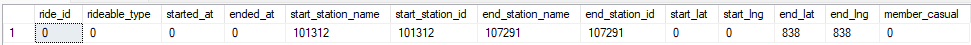

As results, we are getting:
 - start_station_name and start_station_id have 101312 Null rows
 - end_station_name and end_station_id have 107291 Null rows
 - end_lat and end_lng have 838 Null rows

In addition, let's do a recheck to see if the number of nulls could match up between "start and end station and id.--Checking Null values from all columns


In [ ]:
 Select Count(ride_id) AS start_end_stationname_null
From dbo.['202309-divvy-tripdata$']
Where start_station_name IS NULL AND end_station_name is NULL

Select Count(ride_id) as start_end_stationid_null
From dbo.['202309-divvy-tripdata$']
Where start_station_id IS NULL AND end_station_id is NULL


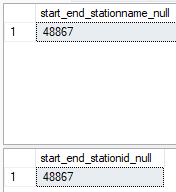

Both sets of queries returned the same amount of observations as 48867, which means it's all normal.

In [ ]:
##Checking Inconsistance; If an observation of ride_length is less or equal to 0, then it will be considered as inconsistance data.

Select *,
datediff(Second, started_at, ended_at) AS num_sec
From dbo.['202309-divvy-tripdata$']
Where DATEDIFF(second, started_at, ended_at) <=0


##Returns 220 observations where the length column appears to be a negative number,
##it's better to consult these results to decide either to delete them or populate them with updated information.

In [ ]:
##Then I wish to check the average ride timestamp for both types of users without considering outliers.


SELECT
  member_casual,
  count(*) as rides,
  min(ride_length) AS min_ride_length,
  max(ride_length) AS max_ride_length,
  AVG(DATEDIFF(SECOND, CAST('00:00:00' AS TIME), ride_length)) AS average_ride_sec
FROM dbo.['202309-divvy-tripdata$']
WHERE start_station_name IS NOT NULL AND start_station_id IS NOT NULL AND end_station_name IS NOT NULL AND end_station_id IS NOT NULL AND end_lat IS NOT NULL AND end_lng IS NOT NULL
  AND (datediff(MINUTE, started_at, ended_at) >= 1
  AND datediff(Day, started_at, ended_at) < 1) ##We don't wish to count in outliars that their travel record which longer than 1 minute and shorter than 1day.
GROUP BY
  member_casual


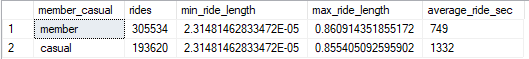

In [ ]:
##Continuing on, here's an improved version of the output by changing min_ride_length and max_ride_length into decimals. However, the bottleneck here is
##I cannot reformat them into timestamp format, it would become invalid data if I do so, maybe I will get a clue of how to fix it in the future.
SELECT
  member_casual,
  count(*) as rides,
  CAST(min(ride_length) AS DECIMAL(18, 6)) AS min_ride_length, 
  max(ride_length) AS max_ride_length,
  AVG(DATEDIFF(SECOND, CAST('00:00:00' AS TIME), ride_length)) AS average_ride_sec
FROM dbo.['202309-divvy-tripdata$']
WHERE start_station_name IS NOT NULL AND start_station_id IS NOT NULL AND end_station_name IS NOT NULL AND end_station_id IS NOT NULL AND end_lat IS NOT NULL AND end_lng IS NOT NULL
  AND (datediff(MINUTE, started_at, ended_at) >= 1
  AND datediff(Day, started_at, ended_at) < 1)
GROUP BY
  member_casual;

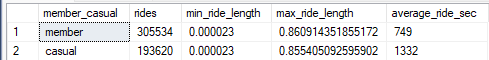


<font size="4">**Data Cleanning**</font>

At this point, after understanding the data I create a table with: 
* no null/missing values
* no start and end IDs 
* ride lengths longer than 1 min and shorter than 1 day. 
This will get me a reliable table to work on named divvy_2022:

In [ ]:
##This query would filter out observations that include information from selected columns that appeared more than once
WITH RowNumCTE AS (
Select *,
    ROW_NUMBER() OVER (
    partition by
                ride_id,
                ride_length
                       Order by
                       ride_id
                              ) row_num

From dbo.['202309-divvy-tripdata$']
--order by ride_id
)
Select *
From RowNumCTE
where row_num > 1
Order by ride_id


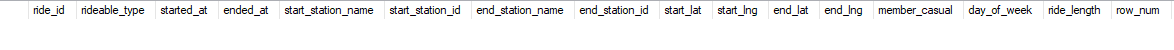

In [ ]:
Option1:
Update the table by extracting all vaild information into a new table:

Select *
INTO #TempTable
FROM dbo.['202309-divvy-tripdata$']
WHERE start_station_name IS NOT NULL
  AND start_station_id IS NOT NULL
  AND end_station_name IS NOT NULL
  AND end_station_id IS NOT NULL
  AND end_lat IS NOT NULL
  AND end_lng IS NOT NULL
  AND DATEDIFF(MINUTE, started_at, ended_at) >= 1
  AND DATEDIFF(DAY, started_at, ended_at) < 1;



EXEC sp_columns ['202309-divvy-tripdata$']

## The Code above is to check the format of each column from the original table, then establish the new table in the same format could ensure the data's integrity.

Drop table if exists CleanSeptemberData
Create table CleanSeptemberData(
 ride_id nvarchar (255),
 rideable_type nvarchar(255),
 started_at datetime,
 ended_at datetime,
 Start_station_name nvarchar(255),
 start_station_id nvarchar(255),
 end_station_name nvarchar(255),
 end_station_id nvarchar(255),
 start_lat float,
 start_lng float,
 end_lat float,
 end_lng float,
 member_causal nvarchar(255),
 day_of_week float,
 ride_length float)

## There we would have a table with clean data.
 Insert into CleanSeptemberData
 Select *
 From #temptable


Option2:
Delete every observation of data which include null from current table


Select *       ##After confirmation, replace "Select *" with "Delete"
FROM dbo.['202309-divvy-tripdata$']
WHERE start_station_name IS NULL
  OR start_station_id IS NULL
  OR end_station_name IS NULL
  OR end_station_id IS NULL
  OR end_lat IS NULL
  OR end_lng IS NULL
  AND DATEDIFF(MINUTE, started_at, ended_at) >= 1
  AND DATEDIFF(DAY, started_at, ended_at) < 1;

##This deletion would remove more than 100K lines of record out from a total of 670K,
##Because the dataset we are working on is fictional we can simply remove invalid data for absolute statistical accuracy.
##In actual cases it's better to consult with others before deleting anything.

<font size="5">**Analyze**</font>

Now that the data is clean, I proceed to run queries on the table divvy_2022 that will support the insights and the visualizations I want to share with the stakeholders. 
The visualizations are to be generated on Tableau.

Those visualizations are summaries in which user types (member vs casual) can be compared regarding device preference, ride lengths, seasonality, location preference.

In [ ]:
##Catagorizing the overall record into user's type and bike's type.
SELECT
  member_casual, rideable_type, COUNT(*) AS total_trips
FROM dbo.['202309-divvy-tripdata$']
GROUP BY
  member_casual, rideable_type
ORDER BY
  member_casual, total_trips;


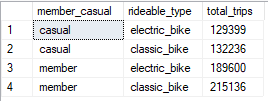

In [ ]:
  ##Here to show which day in a week has the most users.
  SELECT day_of_week, member_casual,
  COUNT(*) AS total_rides
FROM dbo.['202309-divvy-tripdata$']
GROUP BY
  member_casual, day_of_week
ORDER BY
  day_of_week


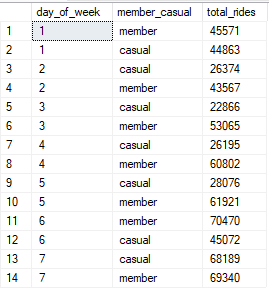

<font size="5">**Share**</font>

The following are the visualizations for September 2022, with a total of 499,154 samples.

**Total rides per rider type**

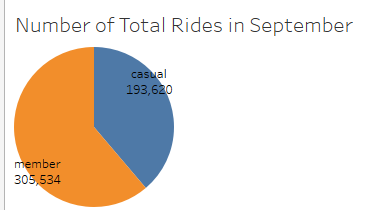
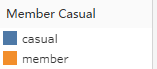


**Ride activity throughout the day of the week**

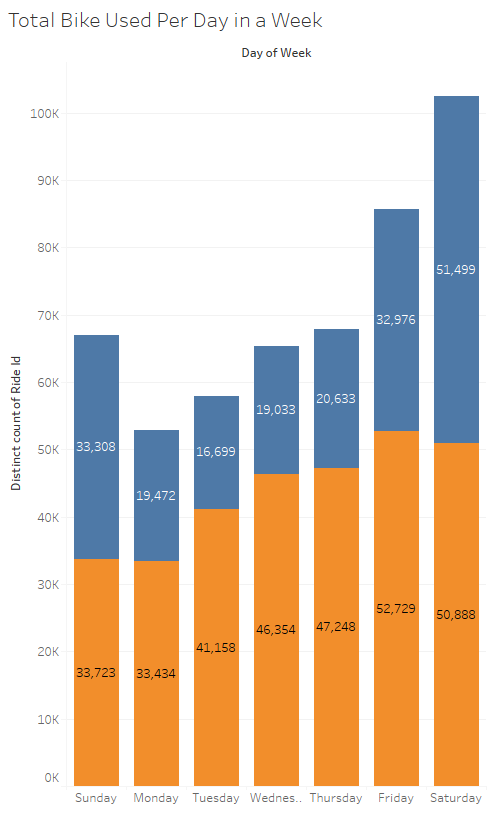
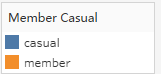

* Overall, Friday and Saturday appear to have the most bike users compared with other days in a week.
* During weekdays, the number of member bike users is significantly higher than casual bike users.

**Rides duration by day of the week**

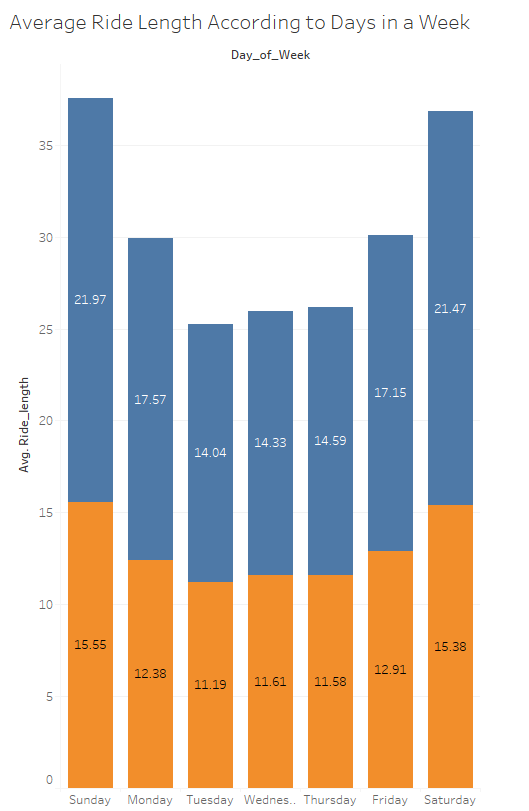
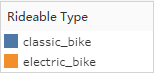

* Classic bikes have longer average travel distances than electric bikes.
* Particularly during the weekend, both types of bike traveling distances reach their highest. 

**Rides according to location and hours within a day**

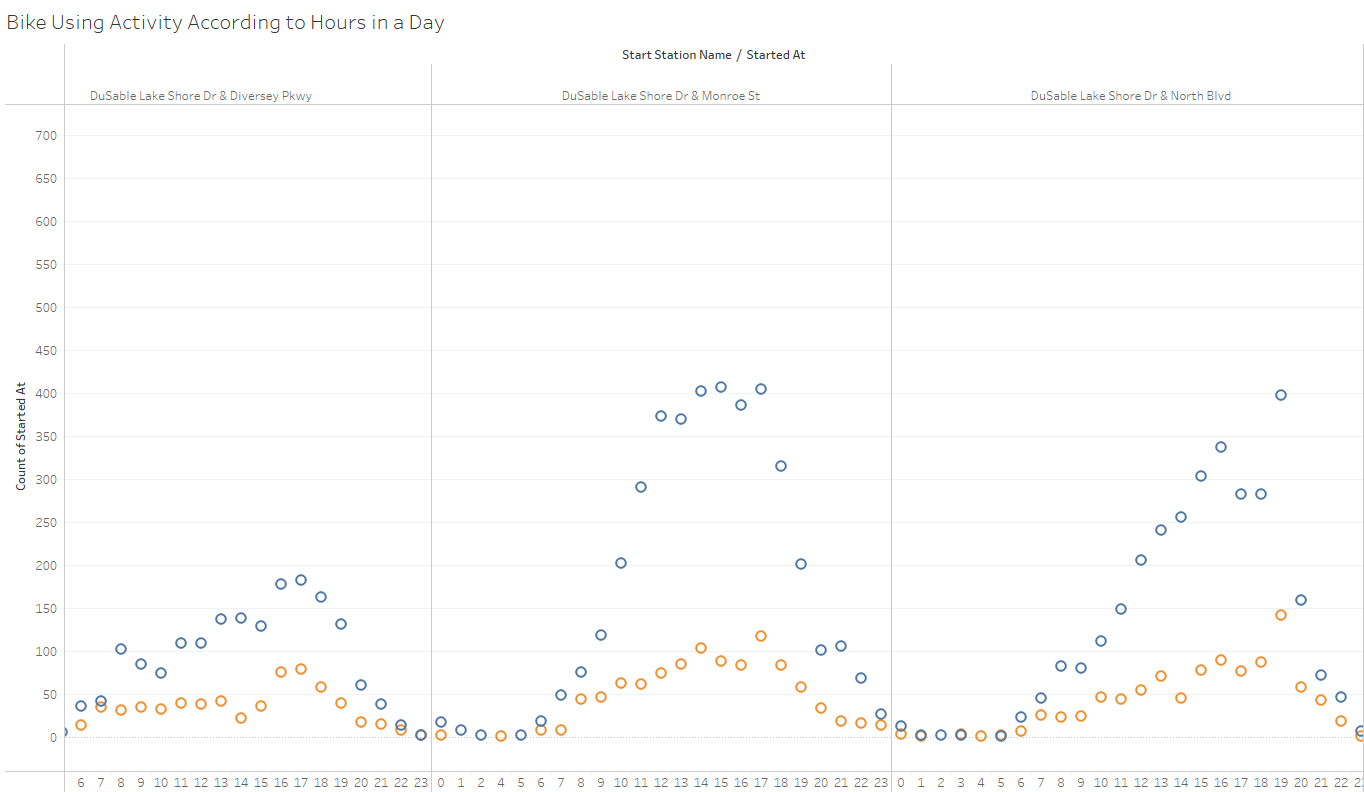
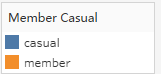

* These are three randomly picked locations, throughout the day the bike usage rate is higher, especially during 10:00 AM to 8:00PM


**Busiest Stations**

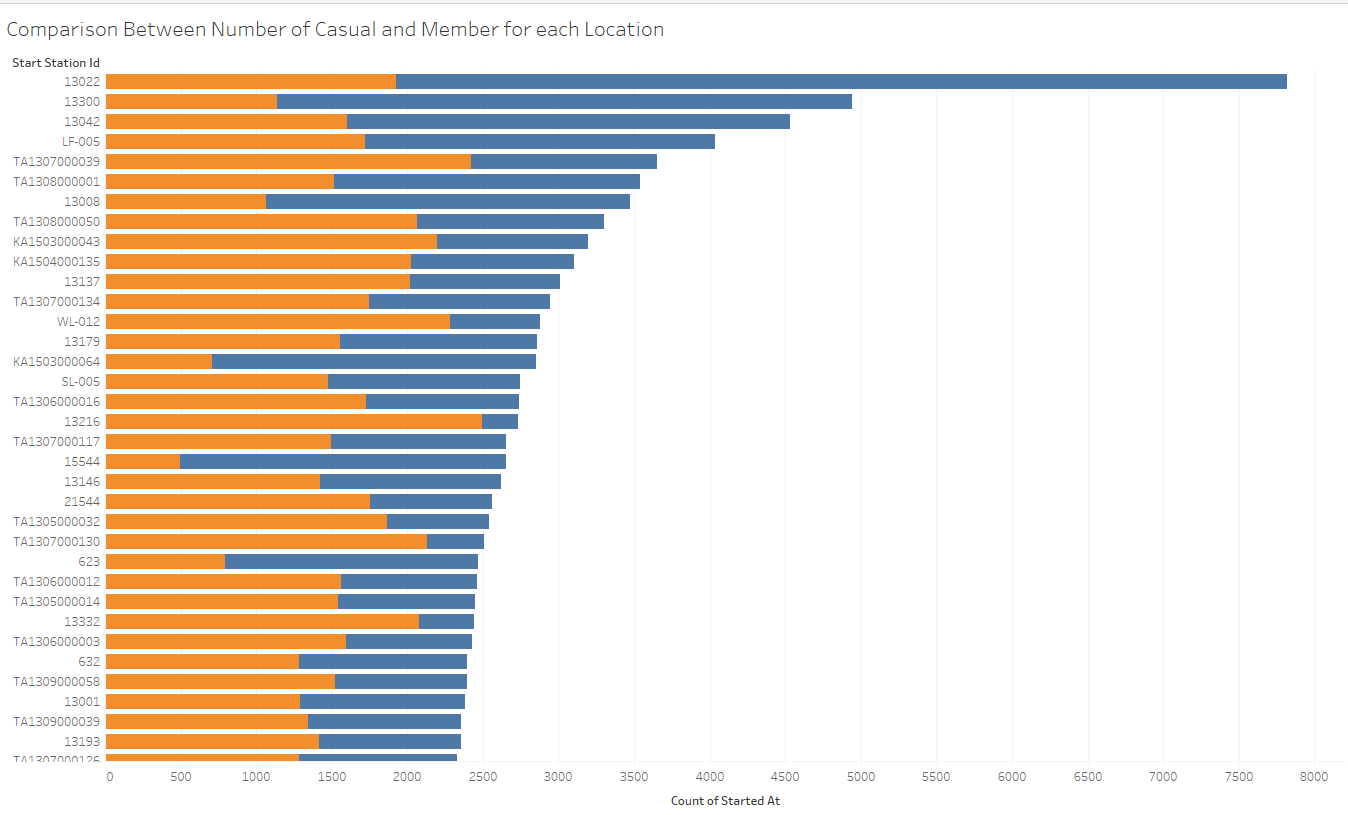
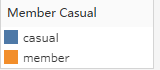

* Station IDs with "13022", "13300", "13042", and "LF-005" are the top 4 stations with the highest bike usage compared with all other stations.


<font size="5">**Act**</font>

In this part I'll bring back the business task and then list my findings and recommendations.

**Business Task**

In order to drive membership conversions, here we analyze the distribution across the dataset from different angles, all related to casual riders and members from September 2022.

**Recommendations**


1. Based on those top 4 busiest stations, it's recommended to provide a sufficient number of bikes to those stations. It might be a key pathway to increase the overall use of bike service.

2. According to the usage comparison between classic bikes and electric bikes, is obvious the usage rate of classic bikes is higher. While I suggested populating more classic bikes according to people's preference, the company should investigate the reason why electric bikes are not as welcomed as traditional bikes, could there be a reason about "difficult to find a charging pillar"... If we make the battery recharge more convenient, would it increase more electric bike user alongwith classic bike user.

3. Any bike maintenance should be done between 8:00 PM to 10:00 AM to avoid a high usage time period of a day.



In [ ]:
**Citation**

##portion of the code in this project has been referenced from a classmate named "Carlos Cuadradoc"
##the work he has done is what I believe to be the most normative procedure of a data analyst project. 

## His work can be found here: https://www.kaggle.com/code/carloscuadradoc/cyclistic-capstone-project-sql

